# Task-Based Merge Rate Analysis

This notebook analyzes merge rates per task type for all agents in the AIDEV-Pop dataset.

## 1. Import Required Libraries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

## 2. Load Merged Data for All Agents

In [17]:
# Define base path to the AIDEV-Pop dataset
base_path = Path("AIDev/aidev-pop")

# List all agent folders
agents = [d.name for d in base_path.iterdir() if d.is_dir()]
print(f"Found {len(agents)} agents: {agents}")

# Load merged data for all agents
merged_data = {}

for agent in agents:
    merged_file = base_path / agent / "merged_prs_commits.csv"
    if merged_file.exists():
        merged_data[agent] = pd.read_csv(merged_file)
        print(f"Loaded {agent}: {merged_data[agent].shape}")
    else:
        print(f"Warning: {merged_file} not found")

print(f"\nSuccessfully loaded data for {len(merged_data)} agents")

Found 5 agents: ['Devin', 'Copilot', 'Cursor', 'OpenAI_Codex', 'Claude_Code']
Loaded Devin: (4829, 17)
Loaded Copilot: (4971, 17)
Loaded Cursor: (1541, 17)
Loaded OpenAI_Codex: (21800, 17)
Loaded Claude_Code: (459, 17)

Successfully loaded data for 5 agents


## 3. Extract All Unique Task Types

In [18]:
# First, let's examine what the task type column is called
print("Sample columns from Devin:")
if 'Devin' in merged_data:
    print(merged_data['Devin'].columns.tolist())
    print("\nSample data:")
    print(merged_data['Devin'].head())

Sample columns from Devin:
['id', 'number', 'title', 'user', 'user_id', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_url', 'html_url', 'body', 'agent', 'title_commit', 'reason', 'type', 'confidence']

Sample data:
           id  number                                              title  \
0  3277367174    3243  Fix #3242: Add reasoning parameter to LLM clas...   
1  3277422683    3730  docs: highlight Neon Local Connect option on c...   
2  3277429161    1895  feat(crawler): replace robotstxt library with ...   
3  3277452738    2557  Add documentation for resolveUsers 50-user bat...   
4  3277544065    2911  fix: resolve Fuel deployment transaction size ...   

                        user    user_id   state            created_at  \
0  devin-ai-integration[bot]  158243242    open  2025-07-30T14:39:48Z   
1  devin-ai-integration[bot]  158243242    open  2025-07-30T14:52:10Z   
2  devin-ai-integration[bot]  158243242    open  2025-07-30T14:53:47Z   
3  devin-ai-integration[bot

In [19]:
# Collect all unique task types from all agents
all_task_types = set()

for agent, df in merged_data.items():
    # Look for task type column (might be 'type', 'task_type', 'conventional_type', etc.)
    task_columns = [col for col in df.columns if 'type' in col.lower() or 'task' in col.lower()]
    print(f"{agent} task-related columns: {task_columns}")
    
    # Assuming the task type column exists, collect unique values
    if task_columns:
        task_col = task_columns[0]  # Take the first match
        unique_tasks = df[task_col].dropna().unique()
        all_task_types.update(unique_tasks)
        print(f"  Found {len(unique_tasks)} unique task types")

print(f"\nTotal unique task types across all agents: {len(all_task_types)}")
print(f"Task types: {sorted(all_task_types)}")

Devin task-related columns: ['type']
  Found 12 unique task types
Copilot task-related columns: ['type']
  Found 12 unique task types
Cursor task-related columns: ['type']
  Found 11 unique task types
OpenAI_Codex task-related columns: ['type']
  Found 12 unique task types
Claude_Code task-related columns: ['type']
  Found 9 unique task types

Total unique task types across all agents: 12
Task types: ['build', 'chore', 'ci', 'docs', 'feat', 'fix', 'other', 'perf', 'refactor', 'revert', 'style', 'test']


## 4. Compute Merge Rates Per Task Type

In [20]:
def compute_merge_rate_per_task(df, task_col):
    """
    Compute merge rate for each task type.
    Merge rate = (number of merged PRs) / (number of closed PRs)
    
    Following the methodology from agent_merge_rate_exploration.ipynb:
    - closed_count = PRs where closed_at is not null
    - merged_count = PRs where merged_at is not null
    - merge_rate = merged_count / closed_count
    """
    # Filter to only closed PRs (have a closed_at timestamp)
    closed_prs = df[df['closed_at'].notna()].copy()
    
    # Group by task type and compute merge rates
    task_merge_rates = {}
    
    for task_type in closed_prs[task_col].dropna().unique():
        task_prs = closed_prs[closed_prs[task_col] == task_type]
        closed_count = len(task_prs)
        merged_count = task_prs['merged_at'].notna().sum()
        merge_rate = merged_count / closed_count if closed_count > 0 else float('nan')
        
        task_merge_rates[task_type] = {
            'closed_count': closed_count,
            'merged_count': merged_count,
            'merge_rate': merge_rate
        }
    
    return task_merge_rates

# Compute merge rates for all agents
agent_task_merge_rates = {}

for agent, df in merged_data.items():
    # Find the task type column
    task_columns = [col for col in df.columns if 'type' in col.lower() or 'task' in col.lower()]
    
    if task_columns:
        task_col = task_columns[0]
        print(f"\n{agent}: Computing merge rates using column '{task_col}'")
        agent_task_merge_rates[agent] = compute_merge_rate_per_task(df, task_col)
        
        # Display summary
        print(f"  Found {len(agent_task_merge_rates[agent])} task types with data")
    else:
        print(f"\n{agent}: No task type column found, skipping")

print("\n" + "="*60)
print("Merge rate computation complete!")
print("="*60)


Devin: Computing merge rates using column 'type'
  Found 12 task types with data

Copilot: Computing merge rates using column 'type'
  Found 12 task types with data

Cursor: Computing merge rates using column 'type'
  Found 11 task types with data

OpenAI_Codex: Computing merge rates using column 'type'
  Found 12 task types with data

Claude_Code: Computing merge rates using column 'type'
  Found 9 task types with data

Merge rate computation complete!


In [21]:
# Display merge rates for a sample agent (Devin)
if 'Devin' in agent_task_merge_rates:
    print("Sample: Devin merge rates per task type")
    print("="*60)
    for task_type, rates in sorted(agent_task_merge_rates['Devin'].items()):
        print(f"{task_type:30s}: {rates['merge_rate']:.3f} ({rates['merged_count']}/{rates['closed_count']})")

Sample: Devin merge rates per task type
build                         : 0.587 (37/63)
chore                         : 0.570 (159/279)
ci                            : 0.610 (36/59)
docs                          : 0.727 (442/608)
feat                          : 0.567 (1035/1827)
fix                           : 0.443 (536/1211)
other                         : 0.000 (0/3)
perf                          : 0.361 (22/61)
refactor                      : 0.590 (248/420)
revert                        : 0.667 (4/6)
style                         : 0.680 (17/25)
test                          : 0.532 (59/111)


## 5. Visualize Merge Rates Per Task Type for Each Agent

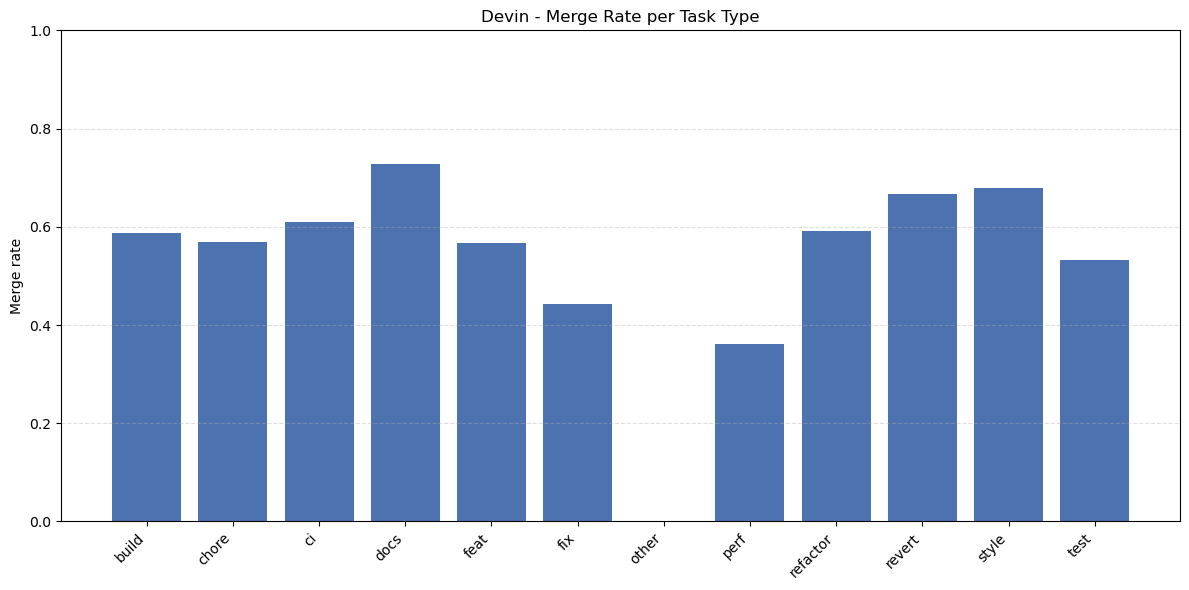


Devin - Task type merge rates:
  build                         : 0.587 (37/63)
  chore                         : 0.570 (159/279)
  ci                            : 0.610 (36/59)
  docs                          : 0.727 (442/608)
  feat                          : 0.567 (1035/1827)
  fix                           : 0.443 (536/1211)
  other                         : 0.000 (0/3)
  perf                          : 0.361 (22/61)
  refactor                      : 0.590 (248/420)
  revert                        : 0.667 (4/6)
  style                         : 0.680 (17/25)
  test                          : 0.532 (59/111)


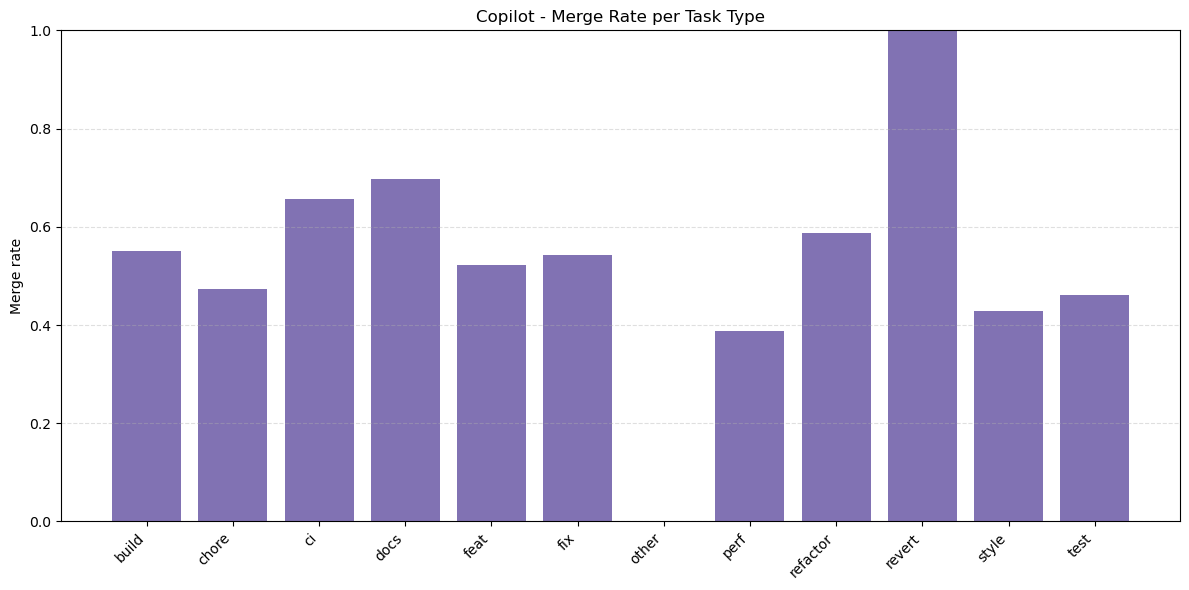


Copilot - Task type merge rates:
  build                         : 0.550 (60/109)
  chore                         : 0.474 (55/116)
  ci                            : 0.656 (42/64)
  docs                          : 0.697 (278/399)
  feat                          : 0.523 (632/1208)
  fix                           : 0.542 (845/1558)
  other                         : 0.000 (0/11)
  perf                          : 0.387 (12/31)
  refactor                      : 0.588 (144/245)
  revert                        : 1.000 (4/4)
  style                         : 0.429 (6/14)
  test                          : 0.462 (61/132)


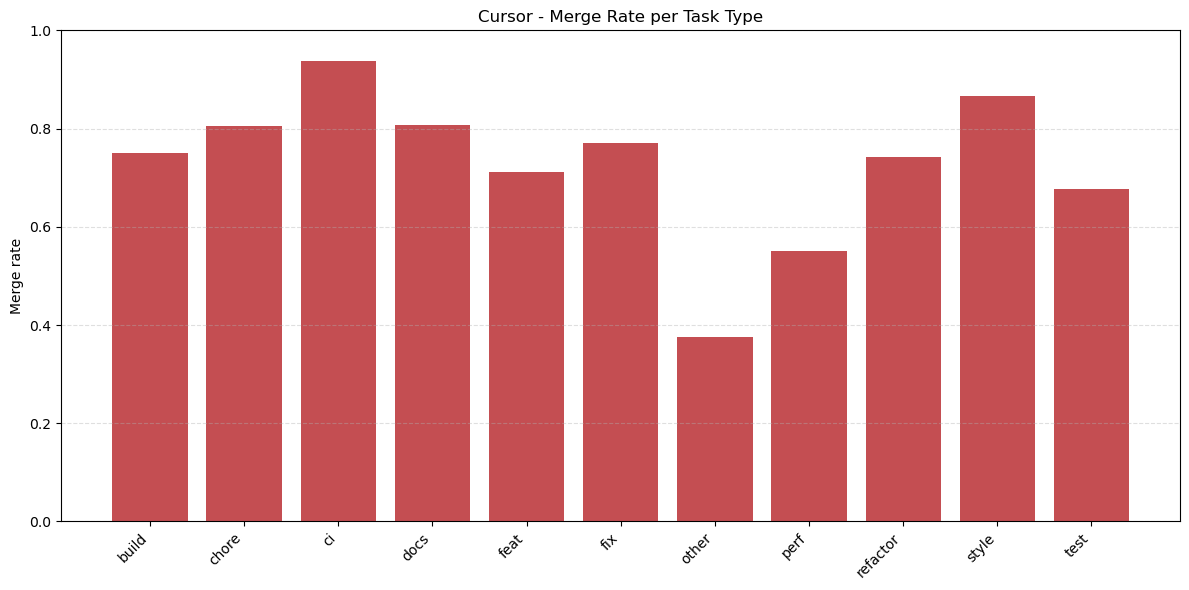


Cursor - Task type merge rates:
  build                         : 0.750 (24/32)
  chore                         : 0.804 (37/46)
  ci                            : 0.938 (15/16)
  docs                          : 0.806 (154/191)
  feat                          : 0.711 (372/523)
  fix                           : 0.770 (281/365)
  other                         : 0.375 (3/8)
  perf                          : 0.550 (11/20)
  refactor                      : 0.742 (72/97)
  style                         : 0.867 (13/15)
  test                          : 0.676 (23/34)


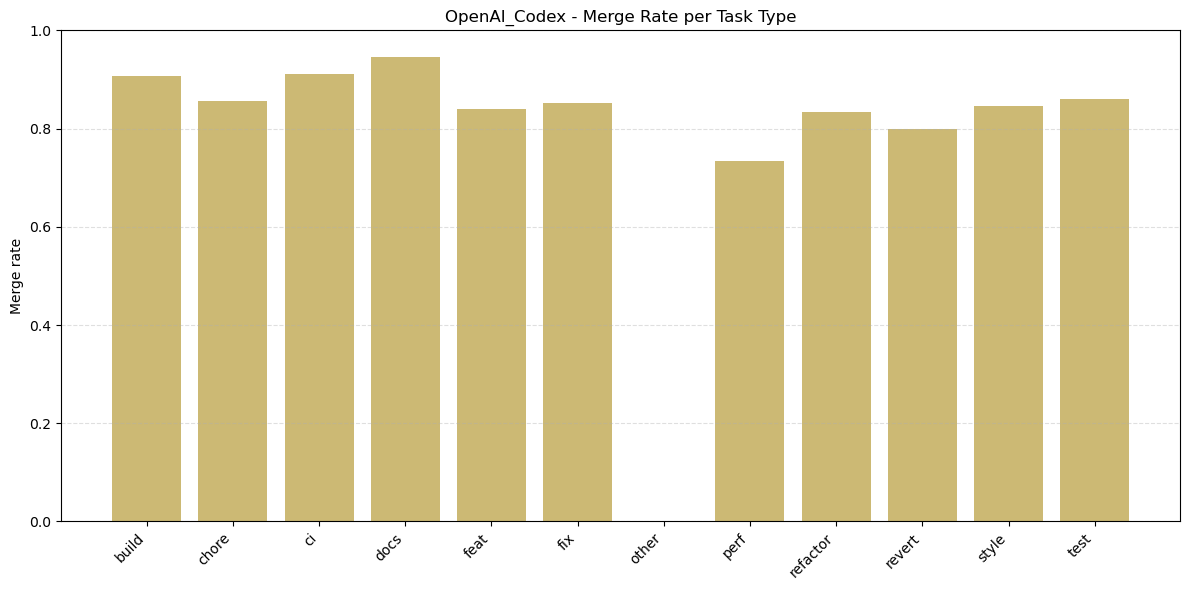


OpenAI_Codex - Task type merge rates:
  build                         : 0.907 (341/376)
  chore                         : 0.855 (355/415)
  ci                            : 0.912 (228/250)
  docs                          : 0.945 (2369/2507)
  feat                          : 0.840 (8089/9626)
  fix                           : 0.852 (3539/4155)
  other                         : 0.000 (0/7)
  perf                          : 0.734 (141/192)
  refactor                      : 0.833 (1127/1353)
  revert                        : 0.800 (4/5)
  style                         : 0.846 (110/130)
  test                          : 0.860 (1701/1977)


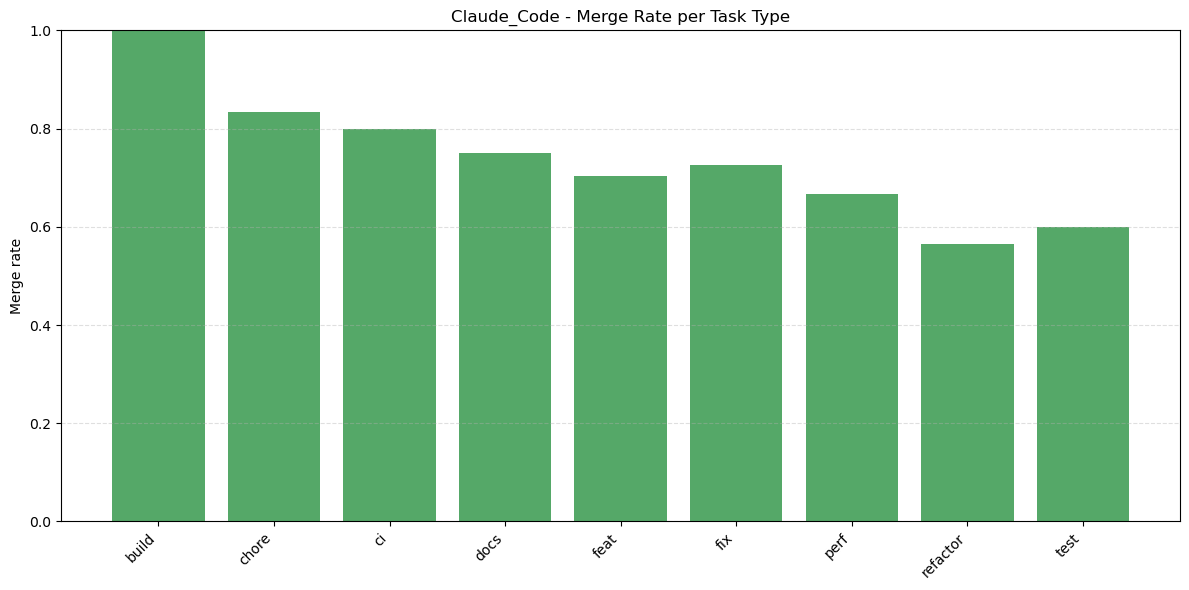


Claude_Code - Task type merge rates:
  build                         : 1.000 (7/7)
  chore                         : 0.833 (10/12)
  ci                            : 0.800 (4/5)
  docs                          : 0.750 (24/32)
  feat                          : 0.703 (142/202)
  fix                           : 0.725 (66/91)
  perf                          : 0.667 (2/3)
  refactor                      : 0.565 (13/23)
  test                          : 0.600 (3/5)


In [22]:
# Create bar plots for each agent, following the style from agent_merge_rate_exploration.ipynb
colors = {
    'Devin': '#4C72B0',
    'Claude_Code': '#55A868',
    'Cursor': '#C44E52',
    'Copilot': '#8172B3',
    'OpenAI_Codex': '#CCB974'
}

for agent, task_rates in agent_task_merge_rates.items():
    # Prepare data for plotting
    task_types = list(task_rates.keys())
    merge_rates = [task_rates[task]['merge_rate'] for task in task_types]
    
    # Sort by task type for consistent display
    sorted_data = sorted(zip(task_types, merge_rates))
    task_types_sorted = [x[0] for x in sorted_data]
    merge_rates_sorted = [x[1] for x in sorted_data]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    color = colors.get(agent, '#4C72B0')
    plt.bar(task_types_sorted, merge_rates_sorted, color=color)
    plt.ylabel("Merge rate")
    plt.title(f"{agent} - Merge Rate per Task Type")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{agent} - Task type merge rates:")
    for task, rate in sorted_data:
        counts = task_rates[task]
        print(f"  {task:30s}: {rate:.3f} ({counts['merged_count']}/{counts['closed_count']})")

## 6. Summary: Compare All Agents on Same Task Types

In [23]:
# Create a comparison DataFrame showing all agents' merge rates for each task type
import numpy as np

# Get all unique task types across all agents
all_tasks = set()
for agent_rates in agent_task_merge_rates.values():
    all_tasks.update(agent_rates.keys())

all_tasks = sorted(all_tasks)

# Build comparison matrix
comparison_data = []
for task in all_tasks:
    row = {'task_type': task}
    for agent in agent_task_merge_rates.keys():
        if task in agent_task_merge_rates[agent]:
            row[agent] = agent_task_merge_rates[agent][task]['merge_rate']
        else:
            row[agent] = np.nan
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("Merge Rate Comparison Across All Agents")
print("="*80)
print(comparison_df.to_string(index=False))

# Save to CSV for further analysis
comparison_df.to_csv("task_merge_rate_comparison.csv", index=False)
print("\nSaved comparison to task_merge_rate_comparison.csv")

Merge Rate Comparison Across All Agents
task_type    Devin  Copilot   Cursor  OpenAI_Codex  Claude_Code
    build 0.587302 0.550459 0.750000      0.906915     1.000000
    chore 0.569892 0.474138 0.804348      0.855422     0.833333
       ci 0.610169 0.656250 0.937500      0.912000     0.800000
     docs 0.726974 0.696742 0.806283      0.944954     0.750000
     feat 0.566502 0.523179 0.711281      0.840328     0.702970
      fix 0.442609 0.542362 0.769863      0.851745     0.725275
    other 0.000000 0.000000 0.375000      0.000000          NaN
     perf 0.360656 0.387097 0.550000      0.734375     0.666667
 refactor 0.590476 0.587755 0.742268      0.832964     0.565217
   revert 0.666667 1.000000      NaN      0.800000          NaN
    style 0.680000 0.428571 0.866667      0.846154          NaN
     test 0.531532 0.462121 0.676471      0.860395     0.600000

Saved comparison to task_merge_rate_comparison.csv


Found 12 task types common to at least 3 agents:
['build', 'chore', 'ci', 'docs', 'feat', 'fix', 'other', 'perf', 'refactor', 'revert', 'style', 'test']


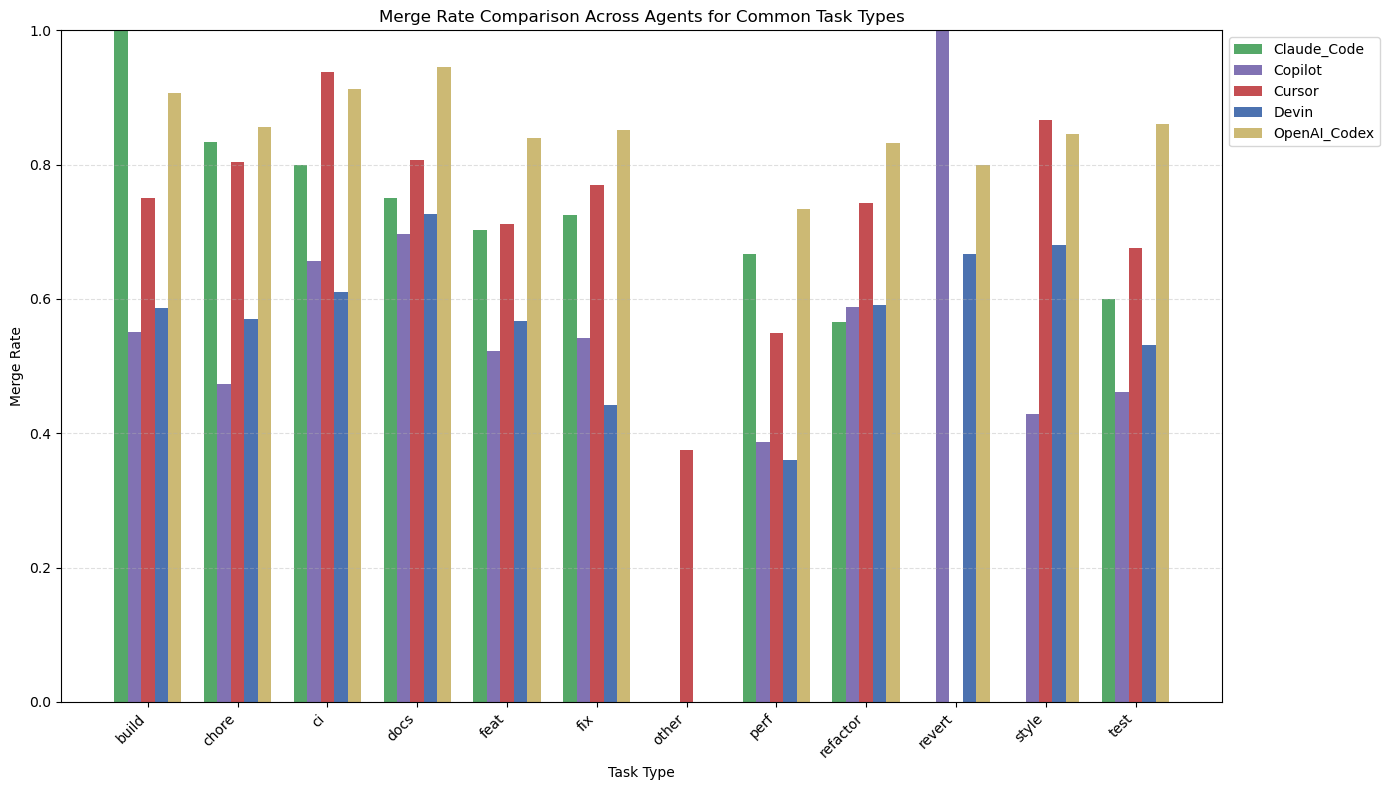

In [24]:
# Visualize comparison: grouped bar chart for selected common task types
# Find task types that appear in at least 3 agents
common_tasks = []
for task in all_tasks:
    count = sum(1 for agent in agent_task_merge_rates.keys() if task in agent_task_merge_rates[agent])
    if count >= 3:
        common_tasks.append(task)

print(f"Found {len(common_tasks)} task types common to at least 3 agents:")
print(common_tasks)

# Create grouped bar chart for common tasks
if common_tasks:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(common_tasks))
    width = 0.15
    multiplier = 0
    
    for agent in sorted(agent_task_merge_rates.keys()):
        rates = [agent_task_merge_rates[agent].get(task, {}).get('merge_rate', 0) for task in common_tasks]
        offset = width * multiplier
        color = colors.get(agent, '#4C72B0')
        ax.bar(x + offset, rates, width, label=agent, color=color)
        multiplier += 1
    
    ax.set_ylabel('Merge Rate')
    ax.set_xlabel('Task Type')
    ax.set_title('Merge Rate Comparison Across Agents for Common Task Types')
    ax.set_xticks(x + width * (len(agent_task_merge_rates) - 1) / 2)
    ax.set_xticklabels(common_tasks, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()
else:
    print("No common task types found across agents")

---

## 7. Compute Resolution Times for Merged Pull Requests

In [25]:
resolution_data = {}
updated_csv_paths = {}

for agent, df in merged_data.items():
    required_cols = {"created_at", "merged_at"}
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"[WARN] {agent}: missing columns {missing_cols}, skipping resolution time computation")
        continue

    # Work on a copy to avoid modifying the original dictionary
    df_copy = df.copy()
    df_copy["created_at"] = pd.to_datetime(df_copy["created_at"], utc=True, errors="coerce")
    df_copy["merged_at"] = pd.to_datetime(df_copy["merged_at"], utc=True, errors="coerce")

    merged_prs = df_copy[df_copy["merged_at"].notna()].copy()
    merged_prs = merged_prs[merged_prs["created_at"].notna()]

    if merged_prs.empty:
        print(f"[INFO] {agent}: no merged PRs with valid timestamps")
        continue

    merged_prs["resolution_time_days"] = (
        (merged_prs["merged_at"] - merged_prs["created_at"]).dt.total_seconds() / 86400
    )

    output_path = base_path / agent / "merged_prs_commits_with_resolution.csv"
    merged_prs.to_csv(output_path, index=False)

    resolution_data[agent] = merged_prs
    updated_csv_paths[agent] = output_path

    mean_resolution = merged_prs["resolution_time_days"].mean()
    print(
        f"[OK] {agent}: saved {len(merged_prs)} merged PRs with resolution times "
        f"(mean {mean_resolution:.2f} days) -> {output_path}"
    )

print("\nCreated resolution-enhanced CSVs for", len(resolution_data), "agents")

[OK] Devin: saved 2595 merged PRs with resolution times (mean 1.67 days) -> AIDev/aidev-pop/Devin/merged_prs_commits_with_resolution.csv
[OK] Copilot: saved 2140 merged PRs with resolution times (mean 3.35 days) -> AIDev/aidev-pop/Copilot/merged_prs_commits_with_resolution.csv
[OK] Cursor: saved 1005 merged PRs with resolution times (mean 0.86 days) -> AIDev/aidev-pop/Cursor/merged_prs_commits_with_resolution.csv
[OK] OpenAI_Codex: saved 18005 merged PRs with resolution times (mean 0.36 days) -> AIDev/aidev-pop/OpenAI_Codex/merged_prs_commits_with_resolution.csv
[OK] Claude_Code: saved 271 merged PRs with resolution times (mean 1.98 days) -> AIDev/aidev-pop/Claude_Code/merged_prs_commits_with_resolution.csv

Created resolution-enhanced CSVs for 5 agents


## 8. Mean Resolution Time per Agent and Task Type

[OK] Devin: computed means for 11 task types
[OK] Copilot: computed means for 11 task types
[OK] Cursor: computed means for 11 task types
[OK] OpenAI_Codex: computed means for 11 task types
[OK] Claude_Code: computed means for 9 task types


agent task_type  mean_resolution_days
44   Claude_Code     build              0.044238
45   Claude_Code     chore              3.929146
46   Claude_Code        ci              0.010677
47   Claude_Code      docs              1.419413
48   Claude_Code      feat              1.712529
49   Claude_Code       fix              2.928581
50   Claude_Code      perf              0.237633
51   Claude_Code  refactor              1.874452
52   Claude_Code      test              0.333295
11       Copilot     build              2.980592
12       Copilot     chore              2.221631
13       Copilot        ci              1.398923
14       Copilot      docs              3.819409
15       Copilot      feat              3.432961
16       Copilot       fix              3.381179
17       Copilot      perf              2.107565
18       Copilot  refactor              3.390102
19       Copilot    revert              1.136236
20       Copilot     style              0.971323
21       Copilot      test              3.172120
22        Cursor     build              0.168875
23        Cursor     chore              0.664248
24        Cursor        ci              0.638332
25        Cursor      docs              0.506973
26        Cursor      feat              0.962207
27        Cursor       fix              0.873736
28        Cursor     other              0.000640
29        Cursor      perf              0.125256
30        Cursor  refactor              1.376865
31        Cursor     style              0.340059
32        Cursor      test              1.691664
0          Devin     build              0.276648
1          Devin     chore              0.534705
2          Devin        ci              0.713774
3          Devin      docs              3.383526
4          Devin      feat              1.762362
5          Devin       fix              0.944773
6          Devin      perf              2.232346
7          Devin  refactor              0.971273
8          Devin    revert              0.669106
9          Devin     style              0.122422
10         Devin      test              1.549316
33  OpenAI_Codex     build              0.175410
34  OpenAI_Codex     chore              1.001306
35  OpenAI_Codex        ci              0.286338
36  OpenAI_Codex      docs              0.188481
37  OpenAI_Codex      feat              0.322844
38  OpenAI_Codex       fix              0.588107
39  OpenAI_Codex      perf              0.248598
40  OpenAI_Codex  refactor              0.434217
41  OpenAI_Codex    revert              0.132295
42  OpenAI_Codex     style              0.111415
43  OpenAI_Codex      test              0.227112

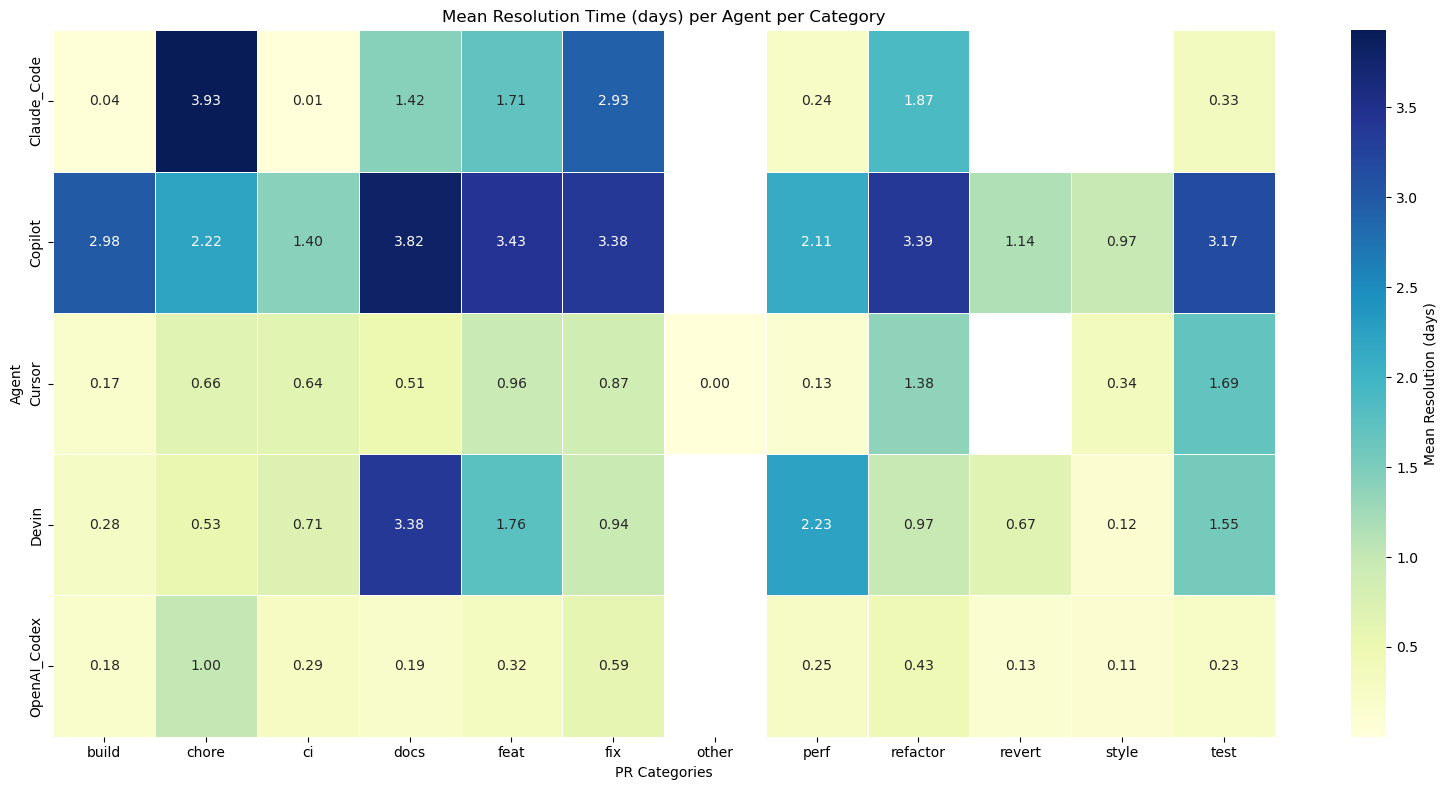

In [26]:
agent_task_resolution = {}
resolution_records = []

for agent, df in resolution_data.items():
    task_columns = [col for col in df.columns if "type" in col.lower() or "task" in col.lower()]
    if not task_columns:
        print(f"[WARN] {agent}: no task-type column found, skipping aggregation")
        continue

    task_col = task_columns[0]
    aggregated = (
        df[[task_col, "resolution_time_days"]]
        .dropna(subset=[task_col, "resolution_time_days"])
        .groupby(task_col)["resolution_time_days"]
        .mean()
        .reset_index()
        .rename(columns={task_col: "task_type", "resolution_time_days": "mean_resolution_days"})
    )

    if aggregated.empty:
        print(f"[INFO] {agent}: no resolvable tasks after filtering")
        continue

    agent_task_resolution[agent] = aggregated

    for _, row in aggregated.iterrows():
        resolution_records.append(
            {
                "agent": agent,
                "task_type": row["task_type"],
                "mean_resolution_days": row["mean_resolution_days"],
            }
        )

    print(f"[OK] {agent}: computed means for {len(aggregated)} task types")

if not resolution_records:
    print("No resolution statistics available to summarize.")
else:
    resolution_summary_df = pd.DataFrame(resolution_records)
    pivot_df = resolution_summary_df.pivot(index="agent", columns="task_type", values="mean_resolution_days")
    pivot_df = pivot_df.sort_index().sort_index(axis=1)

    display(resolution_summary_df.sort_values(["agent", "task_type"]))

    pivot_output = Path("task_mean_resolution_by_agent.csv")
    pivot_df.to_csv(pivot_output)

    plt.figure(figsize=(16, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Mean Resolution (days)"})
    plt.title("Mean Resolution Time (days) per Agent per Category")
    plt.xlabel("PR Categories")
    plt.ylabel("Agent")
    plt.tight_layout()
    plt.show()

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Function to safely min-max scale a DataFrame column-wise
def minmax_scale_df(df):
    scaled_df = df.copy()
    for col in df.columns:
        col_data = df[col]
        valid = col_data.dropna()
        if len(valid) > 1:  # only scale if more than one non-null value
            scaler = MinMaxScaler()
            scaled_values = scaler.fit_transform(valid.values.reshape(-1, 1)).flatten()
            scaled_df.loc[valid.index, col] = scaled_values
        elif len(valid) == 1:
            # If only one value exists, set it to 1.0 (max scaled value)
            scaled_df.loc[valid.index, col] = 1.0
        # if all NaN, leave as NaN
    return scaled_df




# Use original MRT values (lower is better)
mrt_matrix = pivot_df.copy()

# Normalize MRT per task type (lower MRT = higher score)
min_mrt = mrt_matrix.min(axis=0, skipna=True)
max_mrt = mrt_matrix.max(axis=0, skipna=True)
range_mrt = max_mrt - min_mrt
range_safe = range_mrt.replace(0, np.nan)

mrt_score_matrix = mrt_matrix.copy()
for task_col in mrt_score_matrix.columns:
    if pd.isna(range_safe[task_col]):
        mrt_score_matrix[task_col] = mrt_score_matrix[task_col].where(mrt_matrix[task_col].isna(), 1.0)
mrt_score_matrix = mrt_score_matrix.clip(lower=0, upper=1)

# Prepare merge-rate matrix aligned to the MRT matrix
merge_rate_matrix = (
    comparison_df.set_index("task_type").T
    .reindex(mrt_matrix.index)
    .reindex(columns=mrt_matrix.columns)
)

mrt_score_matrix_scaled = minmax_scale_df(mrt_score_matrix)
merge_rate_matrix_scaled = minmax_scale_df(merge_rate_matrix)

# Recompute composite score using scaled matrices
composite_matrix = mrt_score_matrix_scaled + merge_rate_matrix_scaled

# Continue with ranking and summary as before
rank_matrix = composite_matrix.rank(axis=0, ascending=False, method="min")

summary_df = (
    pd.concat(
        [
            composite_matrix.stack().rename("composite_score"),
            mrt_matrix.stack().rename("mean_resolution_days"),
            merge_rate_matrix.stack().rename("merge_rate"),
            rank_matrix.stack().rename("rank")
        ],
        axis=1
    )
    .reset_index()
    .rename(columns={"level_0": "agent", "level_1": "task_type"})
    .dropna(subset=["composite_score", "mean_resolution_days", "merge_rate"])
    .sort_values(["task_type", "rank", "agent"])
)

summary_df.head()

agent task_type  composite_score  mean_resolution_days  merge_rate  \
0    Claude_Code     build         1.000000              0.044238    1.000000   
9        Copilot     build         1.000000              2.980592    0.550459   
42  OpenAI_Codex     build         0.930176              0.175410    0.906915   
20        Cursor     build         0.574284              0.168875    0.750000   
31         Devin     build         0.325124              0.276648    0.587302   

    rank  
0    1.0  
9    1.0  
42   3.0  
20   4.0  
31   5.0

## 9. Normalize Resolution Efficiency and Rank Agents

Saved detailed rankings to task_agent_performance_rankings.csv


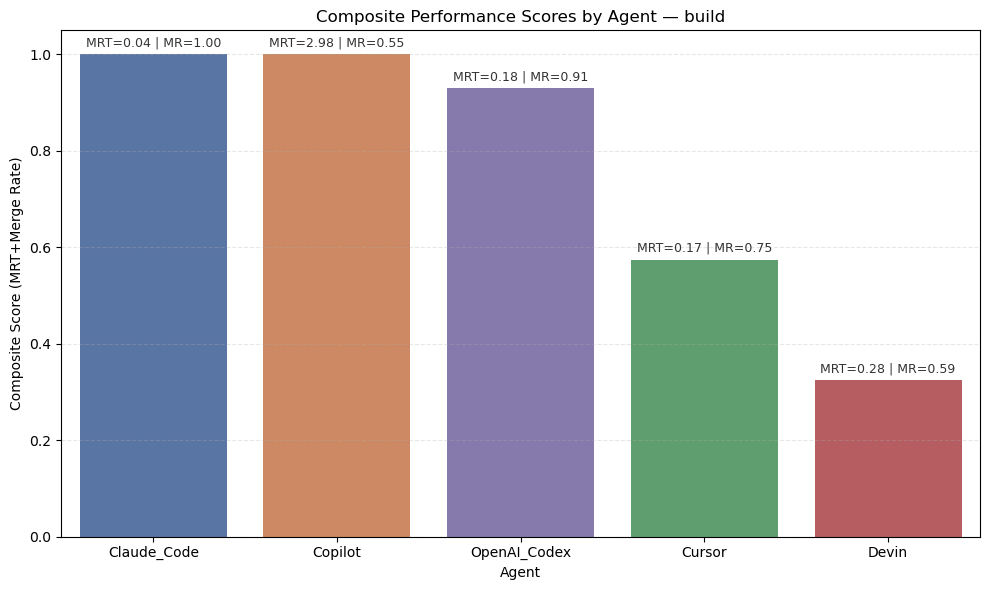

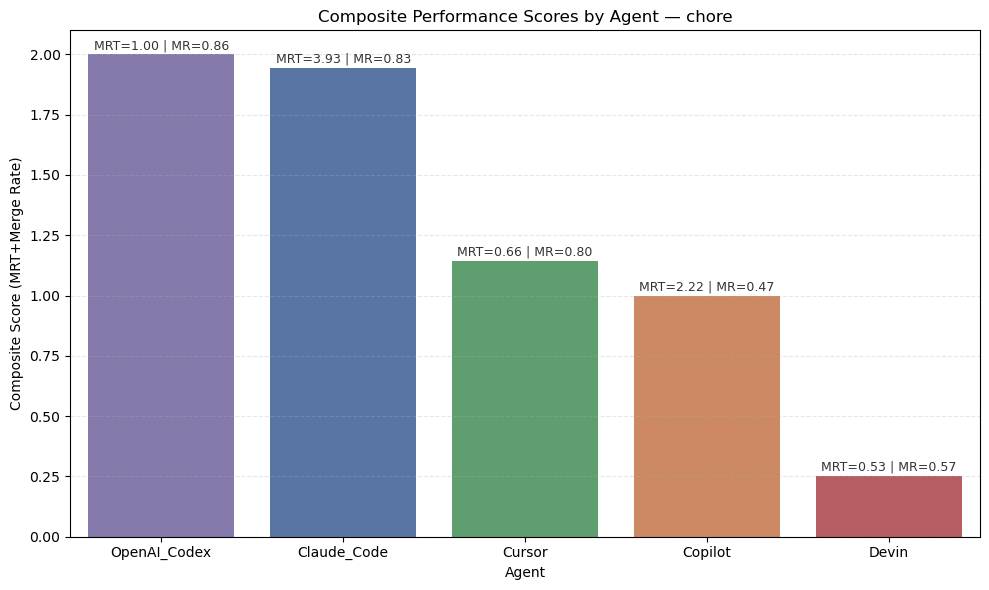

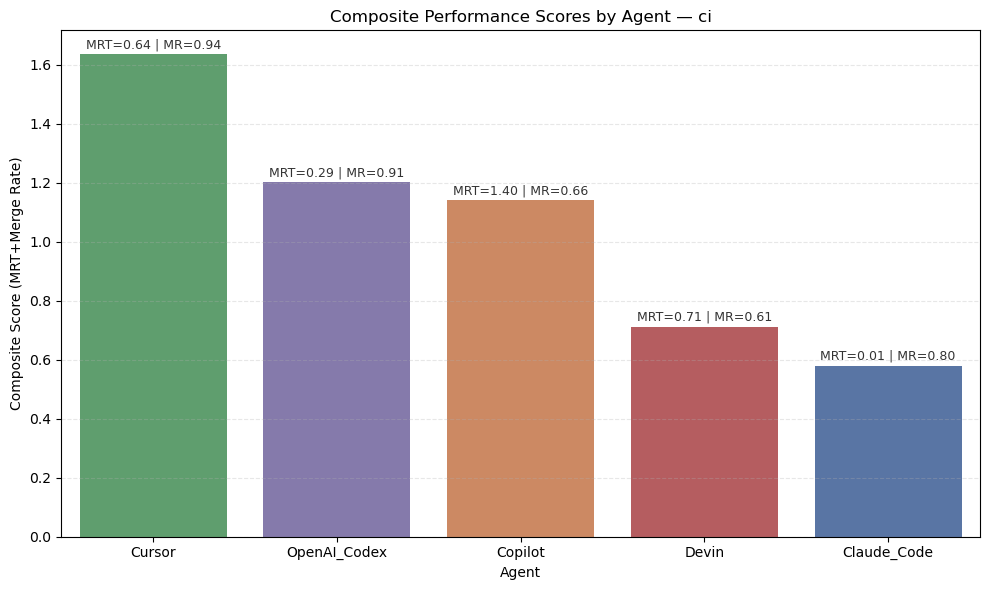

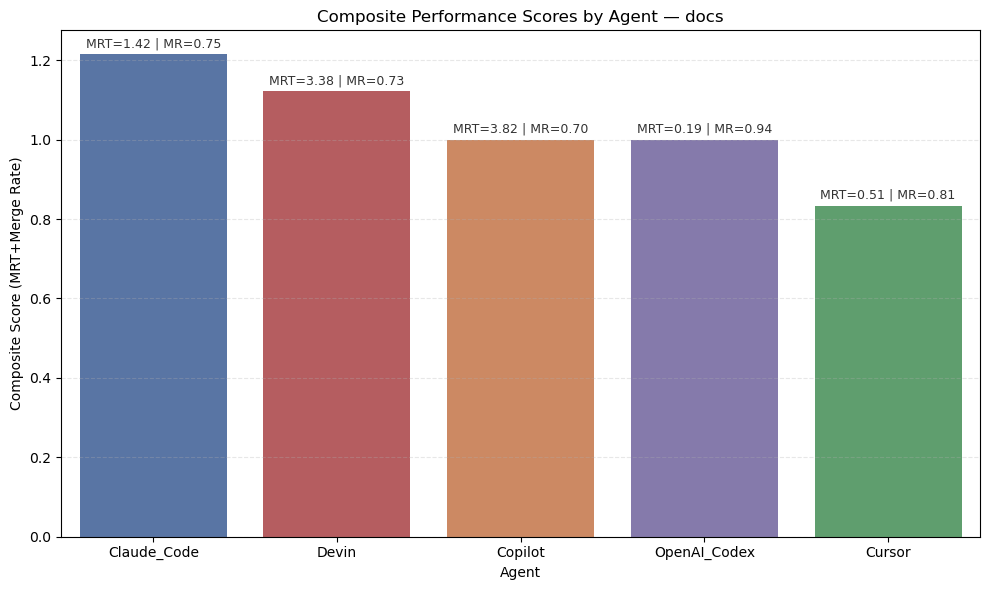

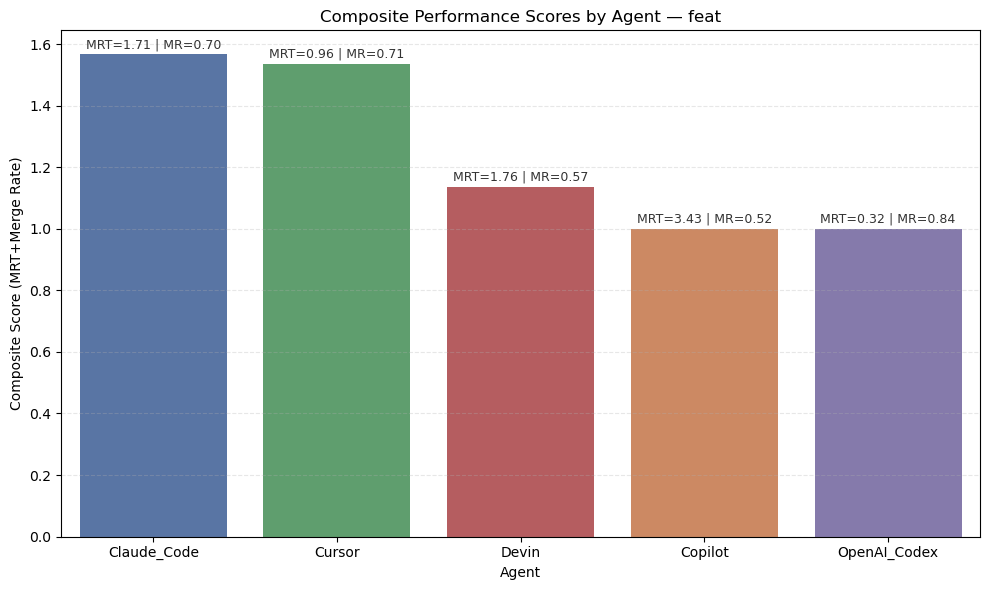

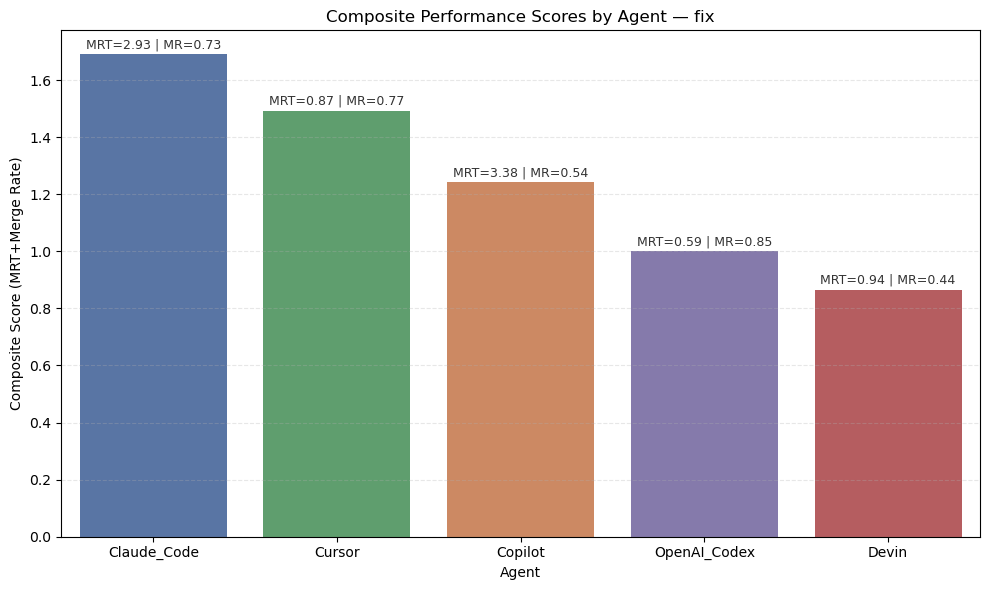

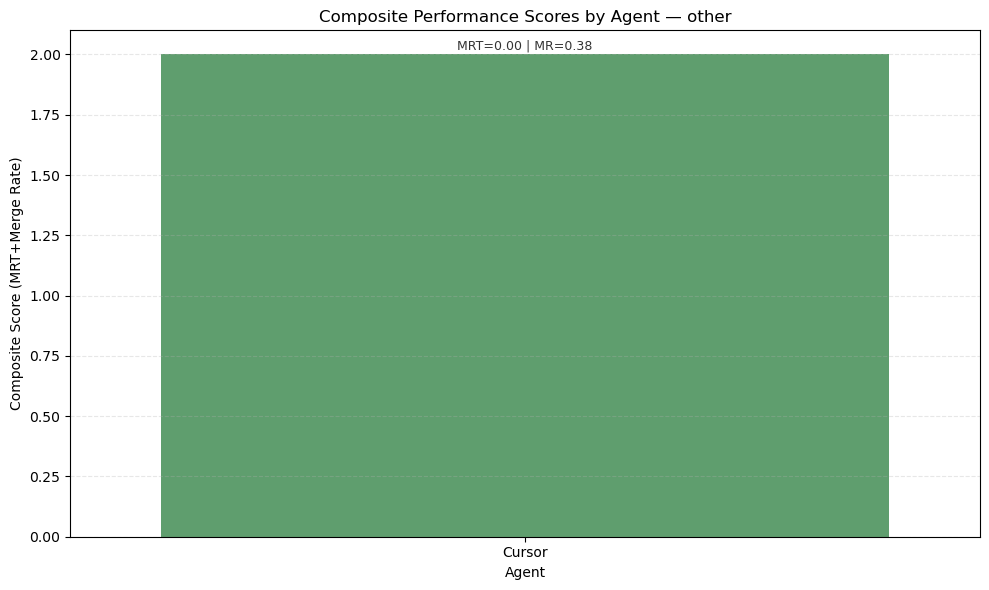

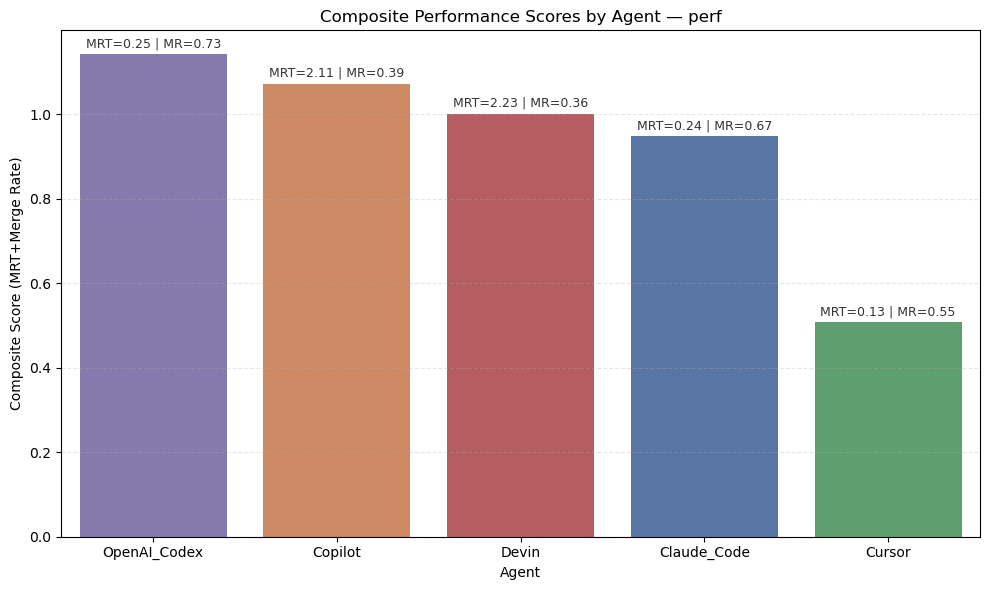

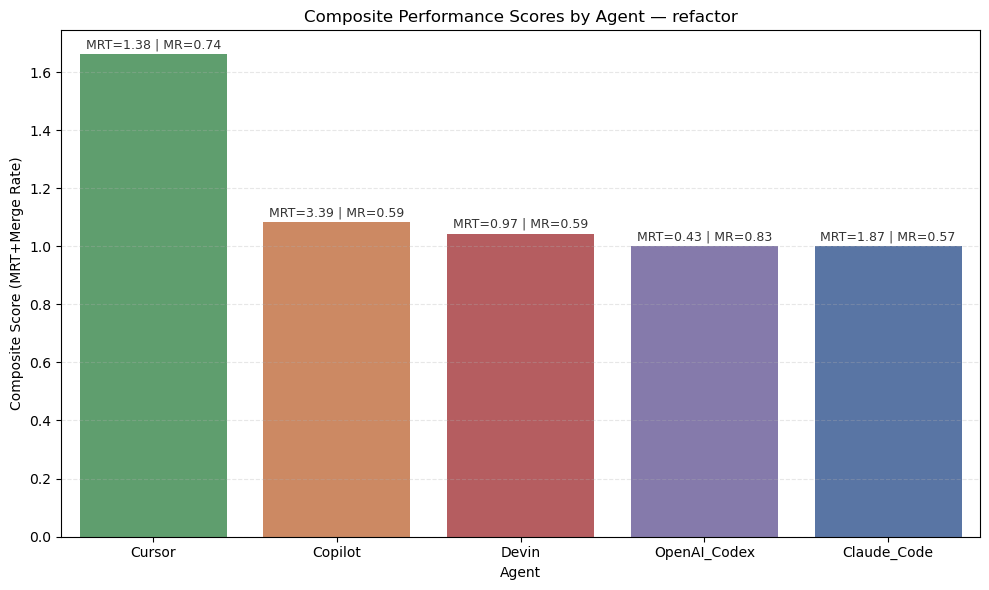

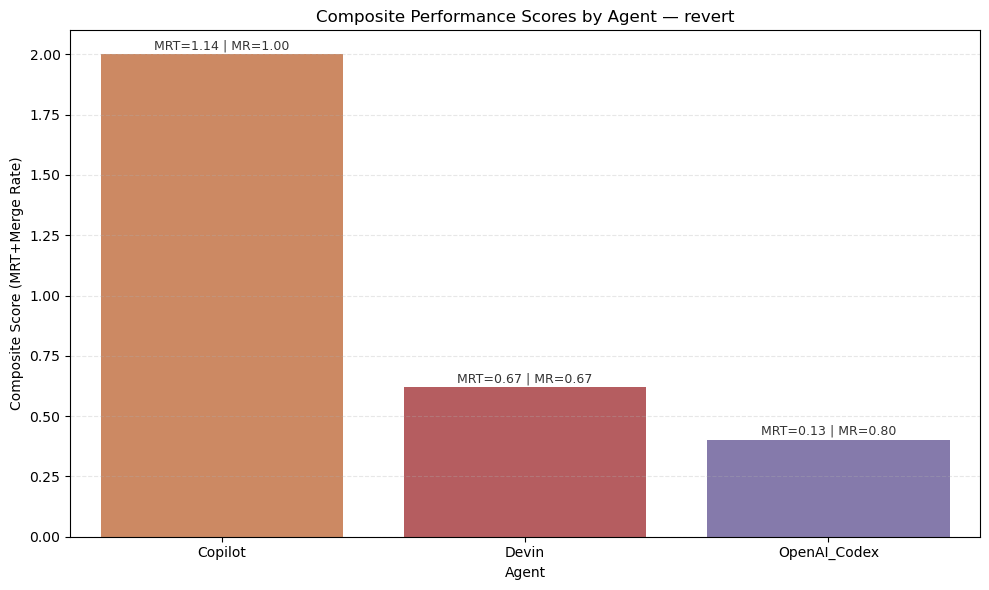

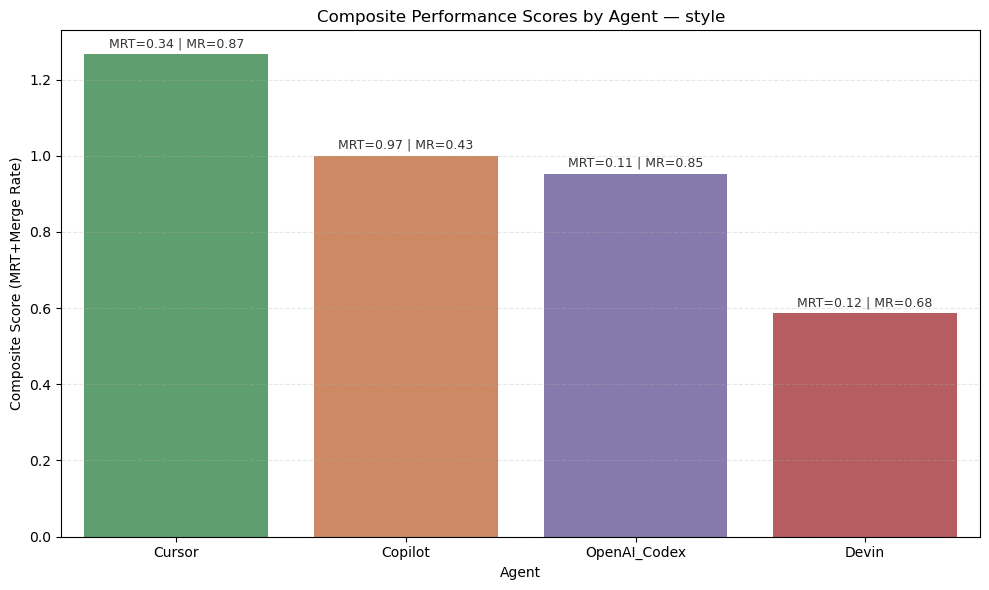

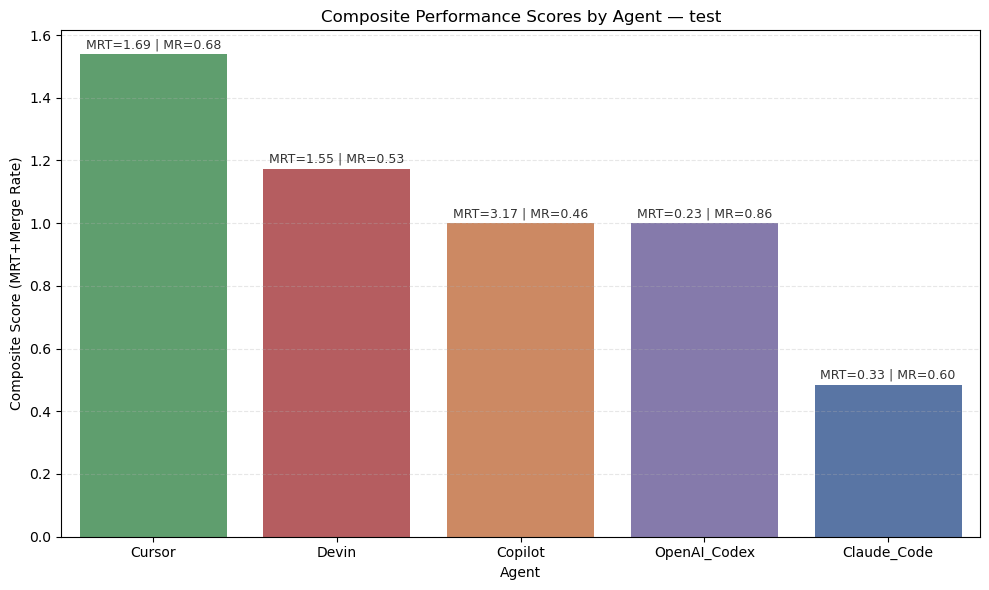

Generated composite-score bar plots for 12 task types and saved rankings summary CSV.


In [28]:
# Ensure summary_df reflects the latest weights
summary_df = summary_df.copy()
composite_matrix = composite_matrix.copy()
rank_matrix = rank_matrix.copy()

def format_row(row):
    return (
        f"Rank {int(row['rank'])} | "
        f"Composite={row['composite_score']:.3f} | "
        f"MRT={row['mean_resolution_days']:.3f} | "
        f"MergeRate={row['merge_rate']:.3f}"
    )

# Summary CSV friendly table
rankings_output = summary_df.copy()
rankings_output["details"] = rankings_output.apply(format_row, axis=1)
rankings_output = rankings_output[
    ["task_type", "agent", "rank", "composite_score", "mean_resolution_days", "merge_rate", "details"]
]
rankings_output.to_csv("task_agent_performance_rankings.csv", index=False)

print("Saved detailed rankings to task_agent_performance_rankings.csv")

# Plot bar charts per task type (with consistent palette)
base_palette = sns.color_palette("deep", n_colors=len(summary_df["agent"].unique()))
agent_order = sorted(summary_df["agent"].unique())
agent_palette = dict(zip(agent_order, base_palette))

unique_tasks = summary_df["task_type"].unique()

for task in sorted(unique_tasks):
    task_slice = (
        summary_df[summary_df["task_type"] == task]
        .sort_values("composite_score", ascending=False)
        .reset_index(drop=True)
    )

    plt.figure(figsize=(10, 6))
    bars = sns.barplot(
        data=task_slice,
        x="agent",
        y="composite_score",
        hue="agent",
        palette=agent_palette,
        dodge=False,
        legend=False,
    )

    for idx, row in task_slice.iterrows():
        bars.text(
            idx,
            row["composite_score"] + 0.01,
            f"MRT={row['mean_resolution_days']:.2f} | MR={row['merge_rate']:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="#333333",
        )

    plt.title(f"Composite Performance Scores by Agent â€” {task}")
    plt.ylabel("Composite Score (MRT+Merge Rate)")
    plt.xlabel("Agent")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

print(
    "Generated composite-score bar plots for",
    len(unique_tasks),
    "task types and saved rankings summary CSV."
)

### Correlation and Hypothesis Testing
We now compute the correlation between merge rate and mean resolution time for each agent across all task types, using both Pearson and Spearman methods. We also perform hypothesis tests to assess statistical significance.

In [29]:
from scipy.stats import pearsonr, spearmanr

correlation_results = []

for agent in summary_df['agent'].unique():
    agent_slice = summary_df[summary_df['agent'] == agent]
    # Drop missing values for both columns
    valid = agent_slice.dropna(subset=['merge_rate', 'mean_resolution_days'])
    if len(valid) < 3:
        print(f"[WARN] {agent}: Not enough data for correlation analysis.")
        continue
    
    # Pearson correlation
    pearson_corr, pearson_p = pearsonr(valid['merge_rate'], valid['mean_resolution_days'])
    # Spearman correlation
    spearman_corr, spearman_p = spearmanr(valid['merge_rate'], valid['mean_resolution_days'])
    
    correlation_results.append({
        'agent': agent,
        'pearson_corr': pearson_corr,
        'pearson_p': pearson_p,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p,
    })
    print(f"{agent}: Pearson r={pearson_corr:.3f} (p={pearson_p:.3g}), Spearman r={spearman_corr:.3f} (p={spearman_p:.3g}), n={len(valid)}")

correlation_df = pd.DataFrame(correlation_results)
correlation_df

Claude_Code: Pearson r=-0.057 (p=0.885), Spearman r=-0.167 (p=0.668), n=9
Copilot: Pearson r=-0.194 (p=0.568), Spearman r=0.200 (p=0.555), n=11
OpenAI_Codex: Pearson r=-0.025 (p=0.941), Spearman r=-0.036 (p=0.915), n=11
Cursor: Pearson r=0.267 (p=0.427), Spearman r=0.082 (p=0.811), n=11
Devin: Pearson r=-0.065 (p=0.849), Spearman r=-0.282 (p=0.401), n=11


agent  pearson_corr  pearson_p  spearman_corr  spearman_p
0   Claude_Code     -0.056762   0.884676      -0.166667    0.668231
1       Copilot     -0.193686   0.568246       0.200000    0.555445
2  OpenAI_Codex     -0.025428   0.940842      -0.036364    0.915468
3        Cursor      0.267256   0.426915       0.081818    0.810990
4         Devin     -0.065145   0.849078      -0.281818    0.401145

In [30]:
from scipy.stats import shapiro

correlation_results = []

for agent in summary_df['agent'].unique():
    agent_slice = summary_df[summary_df['agent'] == agent]
    valid = agent_slice.dropna(subset=['merge_rate', 'mean_resolution_days'])
    if len(valid) < 3:
        print(f"[WARN] {agent}: Not enough data for correlation analysis.")
        continue
    
    # Shapiro-Wilk normality test for merge_rate and mean_resolution_days
    shapiro_merge = shapiro(valid['merge_rate'])
    shapiro_mrt = shapiro(valid['mean_resolution_days'])
    normal_merge = shapiro_merge.pvalue > 0.05
    normal_mrt = shapiro_mrt.pvalue > 0.05
    
    # Choose correlation test
    if normal_merge and normal_mrt:
        corr_type = 'Pearson'
        corr, pval = pearsonr(valid['merge_rate'], valid['mean_resolution_days'])
    else:
        corr_type = 'Spearman'
        corr, pval = spearmanr(valid['merge_rate'], valid['mean_resolution_days'])
    
    correlation_results.append({
        'agent': agent,
        'correlation_type': corr_type,
        'correlation': corr,
        'p_value': pval,
        'shapiro_merge_p': shapiro_merge.pvalue,
        'shapiro_mrt_p': shapiro_mrt.pvalue,
        'n': len(valid)
    })
    print(f"{agent}: {corr_type} r={corr:.3f} (p={pval:.3g}), Shapiro merge p={shapiro_merge.pvalue:.3g}, MRT p={shapiro_mrt.pvalue:.3g}, n={len(valid)}")

correlation_df = pd.DataFrame(correlation_results)
correlation_df

Claude_Code: Pearson r=-0.057 (p=0.885), Shapiro merge p=0.783, MRT p=0.214, n=9
Copilot: Spearman r=0.200 (p=0.555), Shapiro merge p=0.0472, MRT p=0.142, n=11
OpenAI_Codex: Spearman r=-0.036 (p=0.915), Shapiro merge p=0.625, MRT p=0.00686, n=11
Cursor: Pearson r=0.267 (p=0.427), Shapiro merge p=0.256, MRT p=0.599, n=11
Devin: Pearson r=-0.065 (p=0.849), Shapiro merge p=0.599, MRT p=0.164, n=11


agent correlation_type  correlation   p_value  shapiro_merge_p  \
0   Claude_Code          Pearson    -0.056762  0.884676         0.782618   
1       Copilot         Spearman     0.200000  0.555445         0.047195   
2  OpenAI_Codex         Spearman    -0.036364  0.915468         0.625319   
3        Cursor          Pearson     0.267256  0.426915         0.256341   
4         Devin          Pearson    -0.065145  0.849078         0.598815   

   shapiro_mrt_p   n  
0       0.213515   9  
1       0.141962  11  
2       0.006855  11  
3       0.598748  11  
4       0.164024  11

### Composite Score Bar Plots by Task Type
The following visualizations show each agent's composite performance score (sum of normalized MRT and normalized merge rate) for every task type. Bars are ordered by composite score, and annotations indicate rank, normalized MRT, and normalized merge rate.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   task_type     12 non-null     object 
 1   Devin         12 non-null     float64
 2   Copilot       12 non-null     float64
 3   Cursor        11 non-null     float64
 4   OpenAI_Codex  12 non-null     float64
 5   Claude_Code   9 non-null      float64
dtypes: float64(5), object(1)
memory usage: 708.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   agent     5 non-null      object 
 1   build     5 non-null      float64
 2   chore     5 non-null      float64
 3   ci        5 non-null      float64
 4   docs      5 non-null      float64
 5   feat      5 non-null      float64
 6   fix       5 non-null      float64
 7   other     1 non-null      float64
 

/var/folders/kf/9dhrf2c10hqcgvm080qlhzvw0000gn/T/ipykernel_21380/3900291072.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(normalize, 'scaled_merge_rate', invert=False)
/var/folders/kf/9dhrf2c10hqcgvm080qlhzvw0000gn/T/ipykernel_21380/3900291072.py:84: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(normalize, 'scaled_mrt', invert=False)  # No invert here since already inverted globally
/var/folder

Success! Ranking chart saved to 'overall_api_ranking.png'


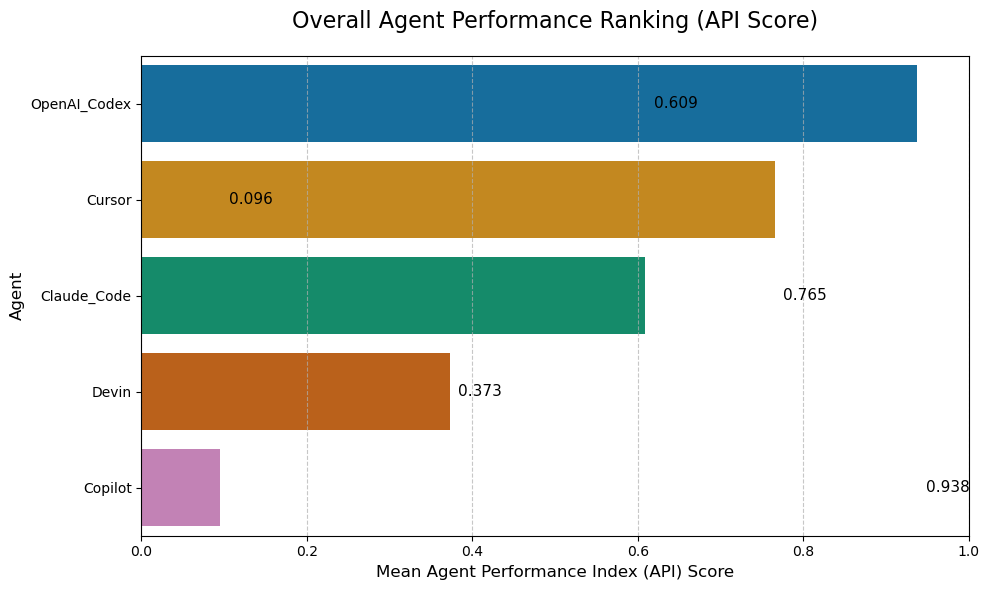

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_overall_ranking_chart():
    """
    Loads the task-level data, calculates the overall API score for each agent,
    and saves a publication-quality horizontal bar chart of the final rankings.
    """
    try:
        # Load the two data files generated by your notebook
        merge_rate_df = pd.read_csv("task_merge_rate_comparison.csv")
        mrt_df = pd.read_csv("task_mean_resolution_by_agent.csv")
    except FileNotFoundError:
        print("Error: Required CSV files ('task_merge_rate_comparison.csv' and 'task_mean_resolution_by_agent.csv') not found.")
        print("Please ensure you have run the 'task_merge_rate_analysis.ipynb' notebook to generate these files.")
        return
    
    print(merge_rate_df.info())
    print(mrt_df.info())

    # --- 1. Reshape Data ---
    # Melt the merge rate data from wide to long format
    mr_data = merge_rate_df.melt(
        id_vars='task_type', 
        var_name='agent', 
        value_name='merge_rate'
    )
    
    # Melt the MRT data from wide to long format (it was incorrectly assumed to be long)
    mrt_data = mrt_df.melt(
        id_vars='agent', 
        var_name='task_type', 
        value_name='mean_resolution_days'
    )

    # --- 2. Merge Metrics ---
    # Combine the two dataframes
    composite_data = pd.merge(mr_data, mrt_data, on=['agent', 'task_type'], how='inner')
    
    # Drop any rows where an agent has no data for a task
    composite_data = composite_data.dropna(subset=['merge_rate', 'mean_resolution_days'])

    # --- 3. Scale Raw Values Using Min-Max (Global Scaling) ---
    # Note: Per the user's request, scale the raw merge_rate and mean_resolution_days using min-max.
    # Matrix shape: composite_data is now long (agent, task_type, merge_rate, mean_resolution_days).
    # Underlying assumptions: Global scaling across all data (not per task), as raw values are scaled before per-task normalization.
    # For merge_rate: Higher is better, so direct min-max scaling.
    # For mean_resolution_days: Lower is better, so scale and invert (1 - scaled) to make higher scaled value better.
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    composite_data['scaled_merge_rate'] = scaler.fit_transform(composite_data[['merge_rate']])
    composite_data['scaled_mrt'] = 1 - scaler.fit_transform(composite_data[['mean_resolution_days']])  # Invert for lower MRT being better
    
    # Now proceed with per-task normalization on the scaled values (to handle task-specific comparisons)
    def normalize(group, col, invert=False):
        """
        Safely normalizes a column (0-1) per group.
        Handles cases where all values are the same to avoid divide-by-zero.
        """
        min_val = group[col].min()
        max_val = group[col].max()
        range_val = max_val - min_val
        
        if range_val == 0:
            # All values in the group are identical.
            return pd.Series(1.0, index=group.index) 
        
        if invert:
            return (max_val - group[col]) / range_val
        else:
            return (group[col] - min_val) / range_val

    # Normalize scaled merge rate (higher is better, no invert needed)
    composite_data['norm_mr'] = composite_data.groupby(
        'task_type', group_keys=False
    ).apply(normalize, 'scaled_merge_rate', invert=False)
    
    # Normalize scaled MRT (already inverted globally, but normalize per task)
    composite_data['norm_mrt'] = composite_data.groupby(
        'task_type', group_keys=False
    ).apply(normalize, 'scaled_mrt', invert=False)  # No invert here since already inverted globally
    
    # Calculate the API Score (Composite Score) with equal weighting
    composite_data['api_score'] = 0.5 * composite_data['norm_mr'] + 0.5 * composite_data['norm_mrt']

    # --- 4. Aggregate Overall Ranking ---
    
    # Calculate the mean API score for each agent across all tasks
    overall_ranking = composite_data.groupby('agent')['api_score'].mean().reset_index()
    
    # Sort from highest to lowest score
    overall_ranking = overall_ranking.sort_values('api_score', ascending=False)

    # --- 5. Plot the Graph ---
    
    plt.figure(figsize=(10, 6))  # Good size for a paper
    
    bars = sns.barplot(
        data=overall_ranking,
        x='api_score',
        y='agent',
        palette='colorblind'  # Use a colorblind-friendly palette
    )
    
    plt.title('Overall Agent Performance Ranking (API Score)', fontsize=16, pad=20)
    plt.xlabel('Mean Agent Performance Index (API) Score', fontsize=12)
    plt.ylabel('Agent', fontsize=12)
    plt.xlim(0, 1.0)  # API score is on a 0-1 scale
    
    # Add data labels (text) to each bar for clarity
    for i, row in overall_ranking.iterrows():
        # Place text just outside the bar
        bars.text(
            row['api_score'] + 0.01,
            i, 
            f"{row['api_score']:.3f}",  # Format to 3 decimal places
            va='center',
            ha='left',
            fontsize=11
        )
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure for your paper
    save_path = 'overall_api_ranking.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"Success! Ranking chart saved to '{save_path}'")

# Run the function
generate_overall_ranking_chart()